# Chapter 2: The impact of hand washing at Vienna General

For additional context see Chapter 2 of [The Virus of Variation](https://www.brokenquality.com/book). Questions? Email us at James.Lehner@gmail.com or QualityIsBroken@gmail.com

In [31]:
# Import libraries
from matplotlib import pyplot as plt
from process_improvement import comparison_charts as cc
import numpy as np
import seaborn as sns
import pandas as pd

import warnings

# This is used to silence a known issue with seabron
warnings.filterwarnings(
    "ignore",
    message="use_inf_as_na option is deprecated",
    category=FutureWarning
)

%matplotlib inline

## Helper function for process statistics

In [32]:
def calc_process_stats(df, value_col, mr_col, round_value=2,
                        E2=2.660, D4=3.268, print_results=False):
    """
    Calculate process limits and return them as a dictionary.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the data.
    value_col : str
        Column name for the individual values (e.g., 'Rate').
    mr_col : str
        Column name for the moving ranges (e.g., 'Moving Range').
    round_value : int
        Number of decimal places to round to.
    E2 : float
        Constant for calculating X chart limits.
    D4 : float
        Constant for calculating mR chart limits.
    print_results : str
        Print results for calculated statistics.

    Returns
    -------
    dict
        Dictionary with mean, average moving range, and process limits.
    """

    ave_mR = round(df[mr_col].mean(), round_value)
    mean = round(df[value_col].mean(), round_value)

    UPL = round(mean + (E2 * ave_mR), round_value)
    calc_LPL = round(mean - (E2 * ave_mR), round_value)
    LPL = max(0, calc_LPL)  # ensure LPL is not negative
    URL = round(D4 * ave_mR, round_value)
    
    results = {
        "Mean": mean,
        "Average mR": ave_mR,
        "UPL": UPL,
        "Calculated LPL": calc_LPL,
        "LPL": LPL,
        "URL": URL
    }
    
    if print_results == True:
        # Print results
        print("Process Statistics:")
        for key, value in results.items():
            print(f"  {key}: {value}")

    return results

## Get the data

The dataset used in this chapter is called:

`vienna-general-death-to-birth-rates-by-clinic.csv`

The data can be found at https://github.com/jimlehner/the-virus-of-variation/tree/main/data.

In [33]:
# Establish the dataset_url
dataset_url = r'https://raw.githubusercontent.com/jimlehner/the-virus-of-variation/refs/heads/main/data/vienna-general-death-to-birth-rates-by-clinic.csv'
# Get data function
def get_data(dataset_url) -> pd.DataFrame:
    return pd.read_csv(dataset_url)

# Get data
df = get_data(dataset_url)

# Specify 'Year' column as dtype string
df['Year'] = df['Year'].astype('string')

# Show df columns
df.columns
df.head()

,Hospital,Clinic,Employee,Year,Births,Deaths,Rate,Note
0,Vienna General Hospital,1st Clinic,Students & Doctors,1833,3737,197,5.3,Second clinic started
1,Vienna General Hospital,1st Clinic,Students & Doctors,1834,2657,205,7.7,NaN
2,Vienna General Hospital,1st Clinic,Students & Doctors,1835,2573,143,5.6,NaN
3,Vienna General Hospital,1st Clinic,Students & Doctors,1836,2677,200,7.5,NaN
4,Vienna General Hospital,1st Clinic,Students & Doctors,1837,2765,251,9.1,NaN


## Drop unnecessary columns

In [34]:
df = df[[#'Hospital', 
         'Clinic',
         #'Employee',
         'Year',
         #'Births',
         #'Deaths',
         'Rate',
         #'Note'
        ]]

# Show df columns
df.columns
df

,Clinic,Year,Rate
0,1st Clinic,1833,5.3
1,1st Clinic,1834,7.7
2,1st Clinic,1835,5.6
3,1st Clinic,1836,7.5
4,1st Clinic,1837,9.1
5,1st Clinic,1838,3.0
6,1st Clinic,1839,5.4
7,1st Clinic,1840,9.2
8,1st Clinic,1841,7.8
9,1st Clinic,1842,15.8


In [35]:
# Split dataframe according to clinic
first_clinic = df[df['Clinic'] == '1st Clinic']
second_clinic = df[df['Clinic'] == '2nd Clinic'].reset_index(drop=True)

# Specify labels column
labels = first_clinic['Year']

# Calculate the moving range
first_clinic = first_clinic.copy()
first_clinic['Moving Range'] = abs(first_clinic['Rate'].diff())

# Show first_clinic dataframe
first_clinic.head()
first_clinic[['Year','Rate']]

,Year,Rate
0,1833,5.3
1,1834,7.7
2,1835,5.6
3,1836,7.5
4,1837,9.1
5,1838,3.0
6,1839,5.4
7,1840,9.2
8,1841,7.8
9,1842,15.8


## Fig 2.2: Time series of death-to-birth ratios at Vienna General Hospital, 1833–1858

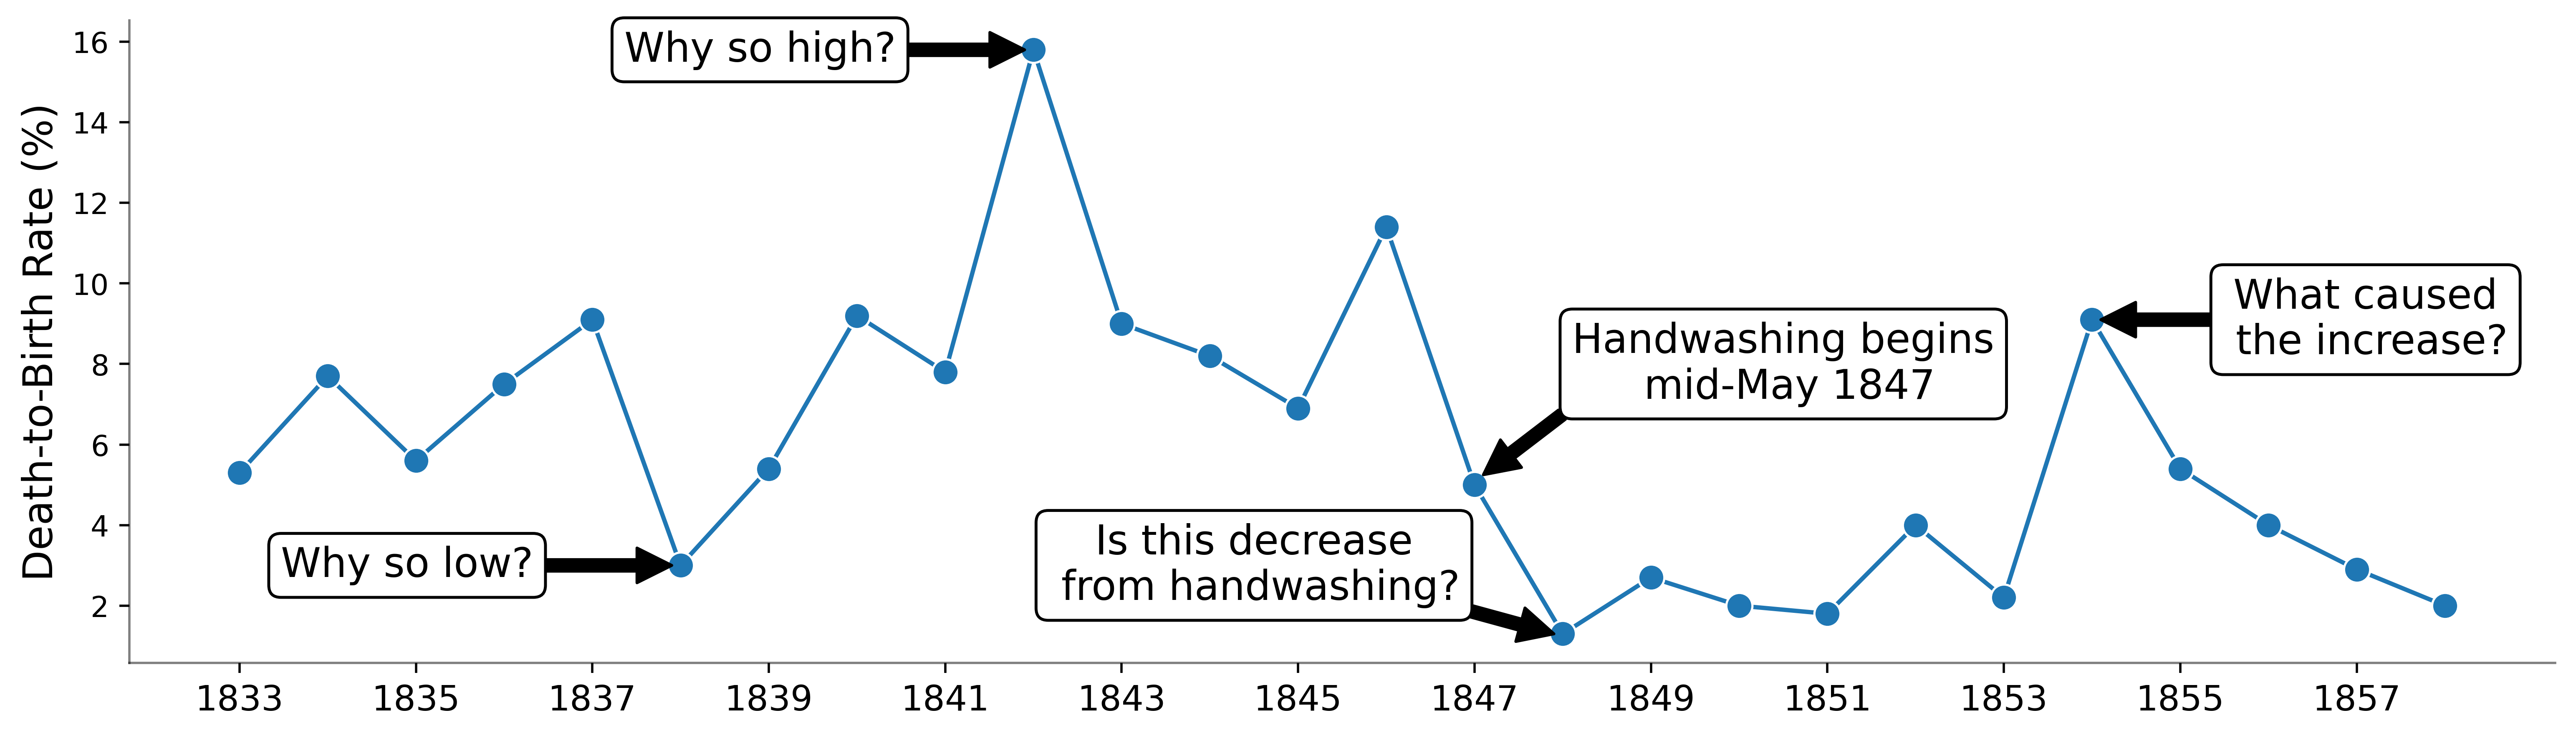

In [36]:
fig, ax = plt.subplots(figsize=(15,4), dpi=500)

sns.lineplot(data=first_clinic, 
             x='Year', 
             y='Rate',
             marker='o', 
             markersize=9)

# Y-label
ax.set_ylabel('Death-to-Birth Rate (%)', fontsize=14)

# X-Axis Formatting
tick_interval = 2
tick_positions = np.arange(0, len(first_clinic), tick_interval)
ax.set_xticks(tick_positions)
ax.set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center', 
                      fontsize=12)

# Despine
sns.despine()
ax.spines[['left','bottom']].set_alpha(0.5)
# Remove xlabel
ax.set_xlabel('')

# Define annotations (text, xy-coordinates, xytext-coordinates)
annotations = [
    ('Why so low?', (4.9,3),(1.9,3)),
    ('Why so high?', (8.9,15.8),(5.9,15.8)),
    ('Is this decrease\n from handwashing?', (14.9, 1.3),(11.5,3)),
    ('Handwashing begins\n mid-May 1847',(14.1,5.25),(17.5,8)), 
    ('What caused\n the increase?', (21.1, 9.1), (24.1, 9.1))
]

# Add annotations using a loop
for text, xy, xytext in annotations:
    ax.annotate(text, xy=xy, xytext=xytext,
                ha='center', va='center', fontsize=14,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'),
                arrowprops=dict(facecolor='black')) 

# Show plot
plt.show()

## Fig 2.3: Time series of death-to-birth rates at Vienna General Hospital with the associated mean, 1833–1858

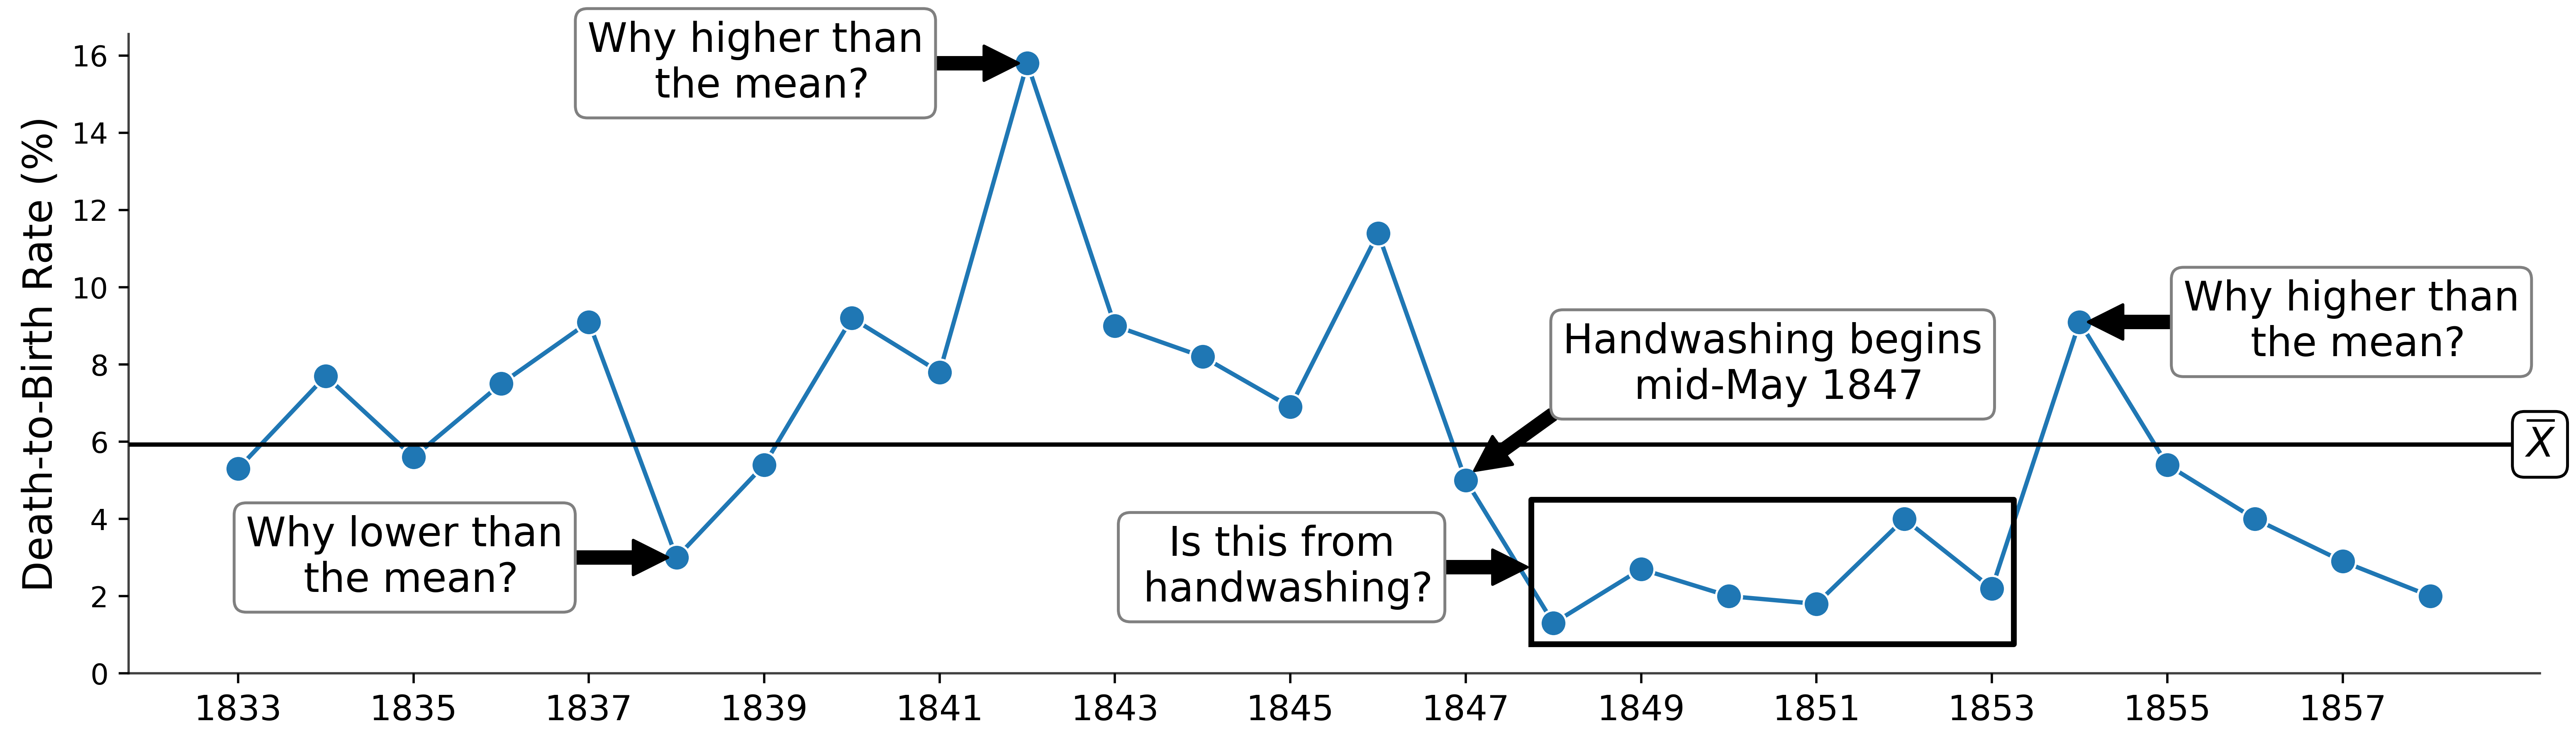

In [37]:
# Calculate the mean of the first clinic ratios
first_clinic_mean = round(first_clinic['Rate'].mean(),2)

# Create figure and axis
fig, ax = plt.subplots(figsize=(15,4), dpi=500)

# Plot data in line plot
sns.lineplot(data=first_clinic, 
             x='Year', 
             y='Rate',
             marker='o', 
             markersize=9)

# Show mean 
ax.axhline(first_clinic_mean, ls='-',c='black')

# bbox properties 
bbox_props_centerline = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
# Add mean label
ax.text(ax.get_xlim()[1], first_clinic_mean, 
#         mean,
        r'$\overline{X}$', 
        color='black', ha='center', va='center', 
        fontsize=14, bbox=bbox_props_centerline)

# Set spine parameters
ax.spines[['top','right']].set_visible(False)
ax.spines[['left','bottom']].set_alpha(0.75)
# Remove xlabel
ax.set_xlabel('')

# Y-label
ax.set_ylabel('Death-to-Birth Rate (%)', fontsize=14)

# X-Axis Formatting
tick_interval = 2
tick_positions = np.arange(0, len(first_clinic), tick_interval)
ax.set_xticks(tick_positions)
ax.set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center', 
                      fontsize=12)

# Define annotations (text, xy-coordinates, xytext-coordinates)
annotations = [
    ('Why lower than\n the mean?', (4.9,3),(1.9,3)),
    ('Why higher than\n the mean?', (8.9,15.8),(5.9,15.8)),
    ('Is this from\n handwashing?', (14.7, 2.75),(11.9,2.75)),
    ('Handwashing begins\n mid-May 1847',(14.1,5.25),(17.5,8)), 
    ('Why higher than\n the mean?', (21.1, 9.1), (24.1, 9.1))
]

# Add annotations using a loop
for text, xy, xytext in annotations:
    ax.annotate(text, xy=xy, xytext=xytext,
                ha='center', va='center', fontsize=14,
                bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round'),
                arrowprops=dict(facecolor='black')) 

# Highlight run of values from 1848 to 1853
start_index = 14.75 
end_index = 20.25  
y_min = 0.75  
y_max = 4.5  

# Add a border using plt.plot()
ax.plot([start_index, end_index, end_index, start_index, start_index], 
         [y_min, y_min, y_max, y_max, y_min], color='black', linewidth=2)

# Show plot
plt.show()

## Fig 2.4: XmR chart of death-to-birth rates at Vienna General Hospital, 1833–1858

### Calculate the process statistics

In [38]:
# Specify round_value
round_value = 2

# Average moving range
ave_mR = round(first_clinic['Moving Range'].mean(), round_value)

# Mean
mean = round(first_clinic['Rate'].mean(), round_value)

# Upper Process Limit (UPL)
UPL = round(mean + (2.660*ave_mR), round_value)

# Lower Process Limit (LPL)
LPL_calc = round(mean - (2.660*ave_mR), round_value)

# In instances where a negative LPL does not make sense the max function 
# is used to return the greater of the two arguemnts.
LPL = max(0, LPL_calc)

# Upper Range Limit (URL)
URL = round(3.268*ave_mR, round_value)

# Print process statistics
print('Ave. mR:', ave_mR)
print('Mean:', mean)
print('UPL:', UPL)
print('LPL (calculated):', LPL_calc)
print('LPL (actual):', LPL)
print('URL:', URL)

Ave. mR: 2.94
Mean: 5.93
UPL: 13.75
LPL (calculated): -1.89
LPL (actual): 0
URL: 9.61


### Generate XmR comparison figure

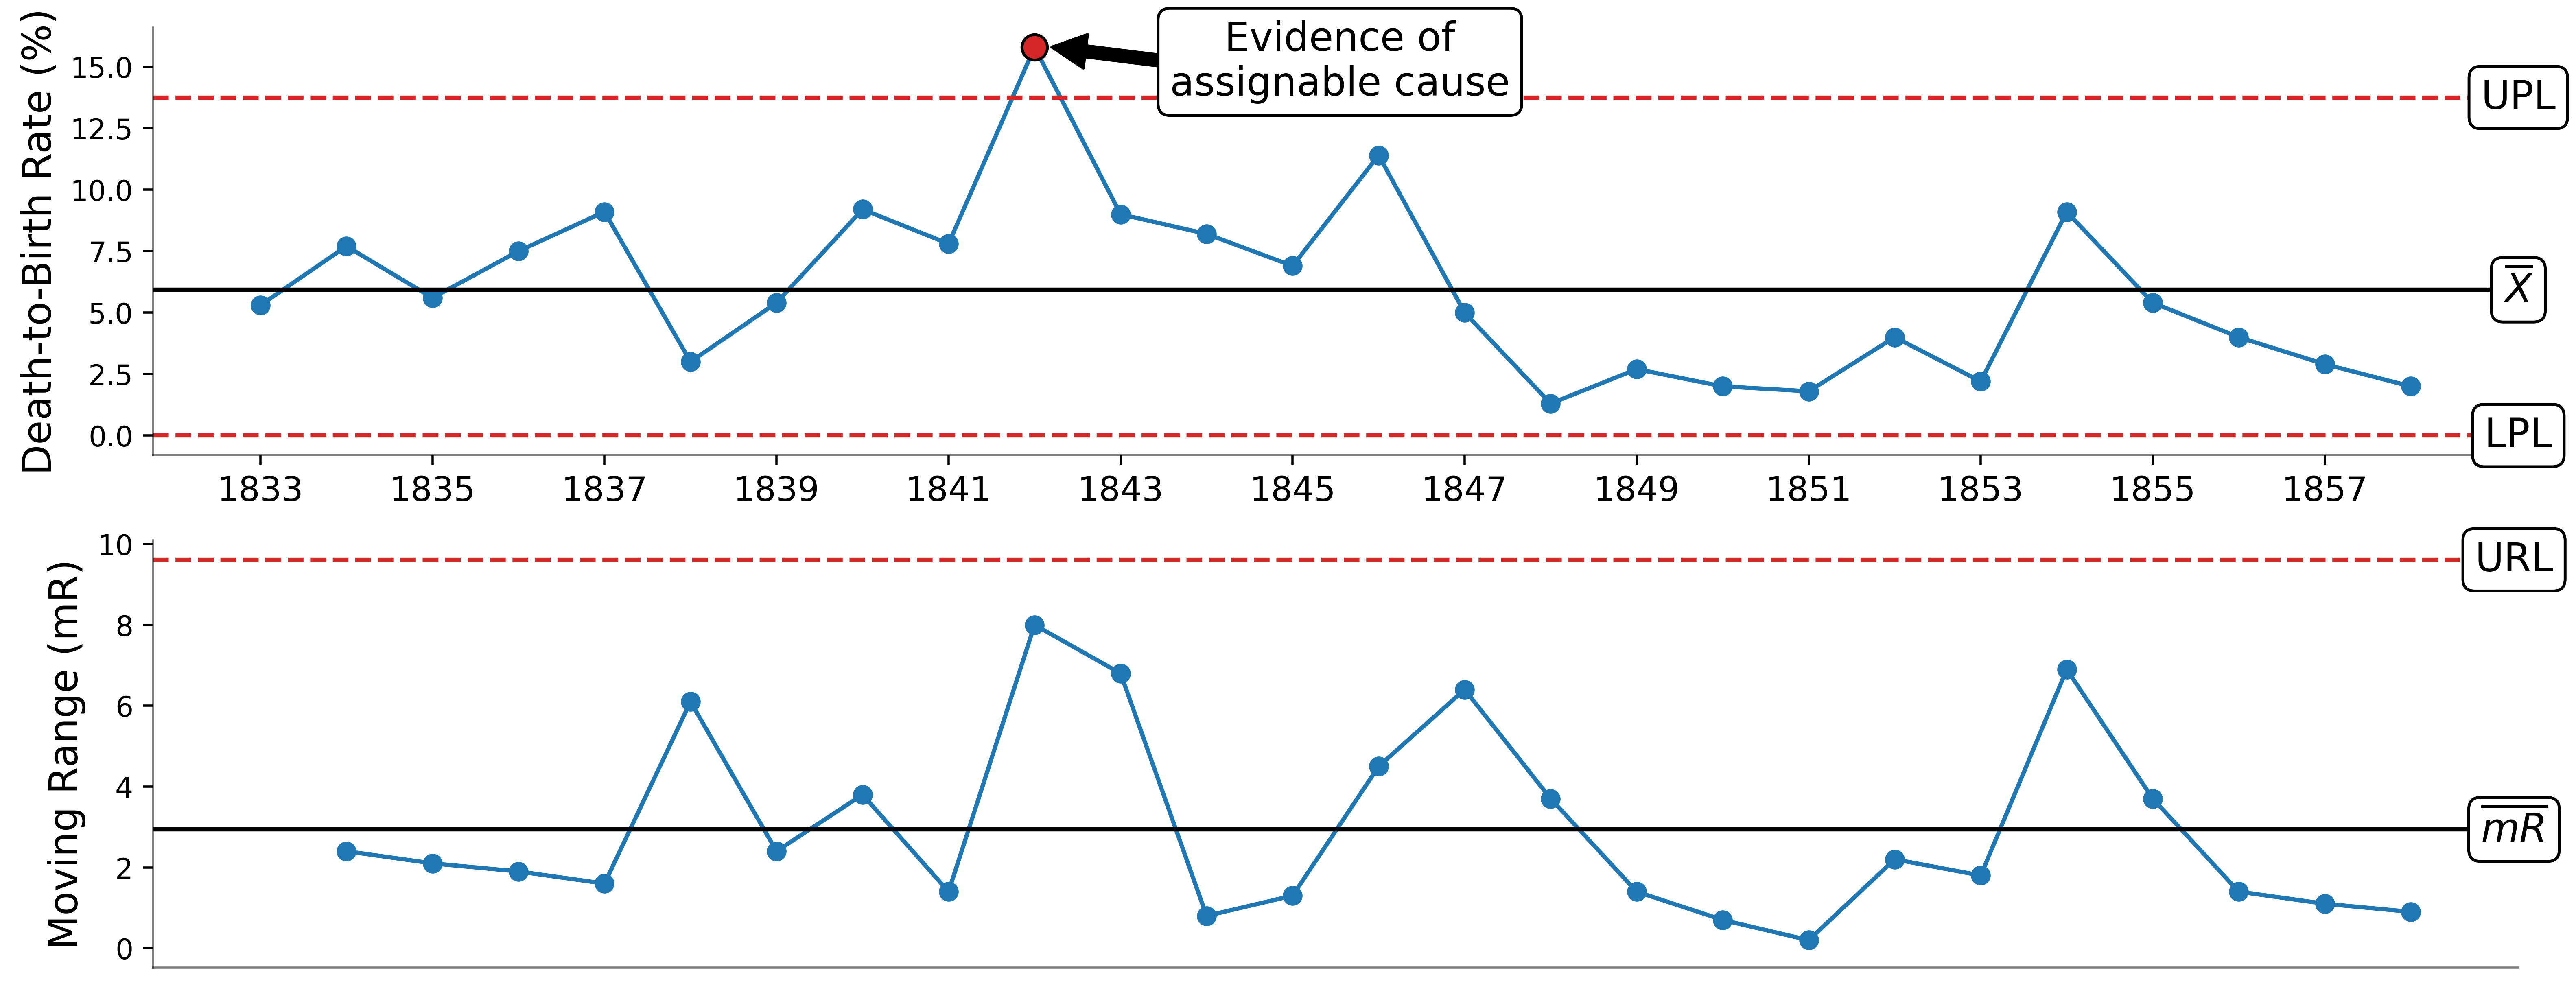

In [39]:
# Specify tickinterval
tickinterval = 2

# Specify data and labels
data = first_clinic['Rate']
labels = first_clinic['Year']
moving_ranges = first_clinic['Moving Range']

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
# Create masking parameters for values greater than URL on mR-chart
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)
url_less = np.ma.masked_where(moving_ranges > URL, moving_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean,'-','black'), (UPL,'--','tab:red'), (LPL,'--','tab:red')]
mrchart_lines = [(ave_mR,'-','black'), (URL,'--','tab:red')]

# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
xchart_labels = [(UPL,UPL),(LPL,LPL),(mean,mean)]
# Create list of tuples with y-coordinate and labels for mR-chart process limit and centerline
mrchart_labels = [(URL,URL),(ave_mR, ave_mR)]

# Create figure and axis
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,6), dpi=500)

# Plot data 
axs[0].plot(labels, data, marker='o')

# Plot moving ranges
axs[1].plot(labels, moving_ranges, marker='o')

# Add masking parameters to color values outside process limits
axs[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
axs[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
# Add masking parameters to color values greater than URL
axs[1].plot(labels, url_greater, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
axs[0].text(axs[0].get_xlim()[1], UPL, 'UPL', color='black', ha='center', va='center', 
            fontsize=14, bbox=bbox_props)
axs[0].text(axs[0].get_xlim()[1], LPL, 'LPL', color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)
axs[0].text(axs[0].get_xlim()[1], mean, r'$\overline{X}$', color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)

axs[1].text(axs[1].get_xlim()[1], URL, 'URL', color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)
axs[1].text(axs[1].get_xlim()[1], ave_mR, r'$\overline{mR}$', color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)

# Add centerline and process limits 
for value, line, color in xchart_lines:
    axs[0].axhline(value, ls=line, c=color)
    
# Add centerline and process limits 
for value, line, color in mrchart_lines:
    axs[1].axhline(value, ls=line, c=color)

# Set the x-tick labels with increased intervals
tick_interval = tickinterval  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
axs[0].set_xticks(tick_positions)
axs[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center', fontsize=12)
# Remove ticks on axs[1]
axs[1].set_xticks([])

# Color values in the moving range white (applies to first value for visual offset)
for xi, yi in zip(labels, moving_ranges):
    if np.isnan(yi):
        plt.plot(xi, 0, marker='x', color='white', markersize=0) 

annotations = [ 
#     ('Handwashing begins\nmid-May 1847', (13.9,5), (10, 3.25)), 
    ('Evidence of\nassignable cause', (9.2,15.8), (12.55, 15.2))
]

# Add annotations using a loop
for text, xy, xytext in annotations:
    axs[0].annotate(text, xy=xy, xytext=xytext,
                ha='center', va='center', fontsize=14,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'),
                arrowprops=dict(facecolor='black'))

# Specify axis labels and title
axs[0].set_xlabel("",fontsize=12)
axs[0].set_ylabel("Death-to-Birth Rate (%)", fontsize=14)
axs[0].set_title("", fontsize=14)

axs[1].set_xlabel("")
axs[1].set_ylabel("Moving Range (mR)", fontsize=14)

# Specify spine visibility 
sns.despine()
for val in (0,1):
    axs[val].spines[['left','bottom']].set_alpha(0.5)

# Show plot
plt.show()

## Fig 2.5: XmR chart of death-to-birth rates at Vienna General Hospital, 1833–1858

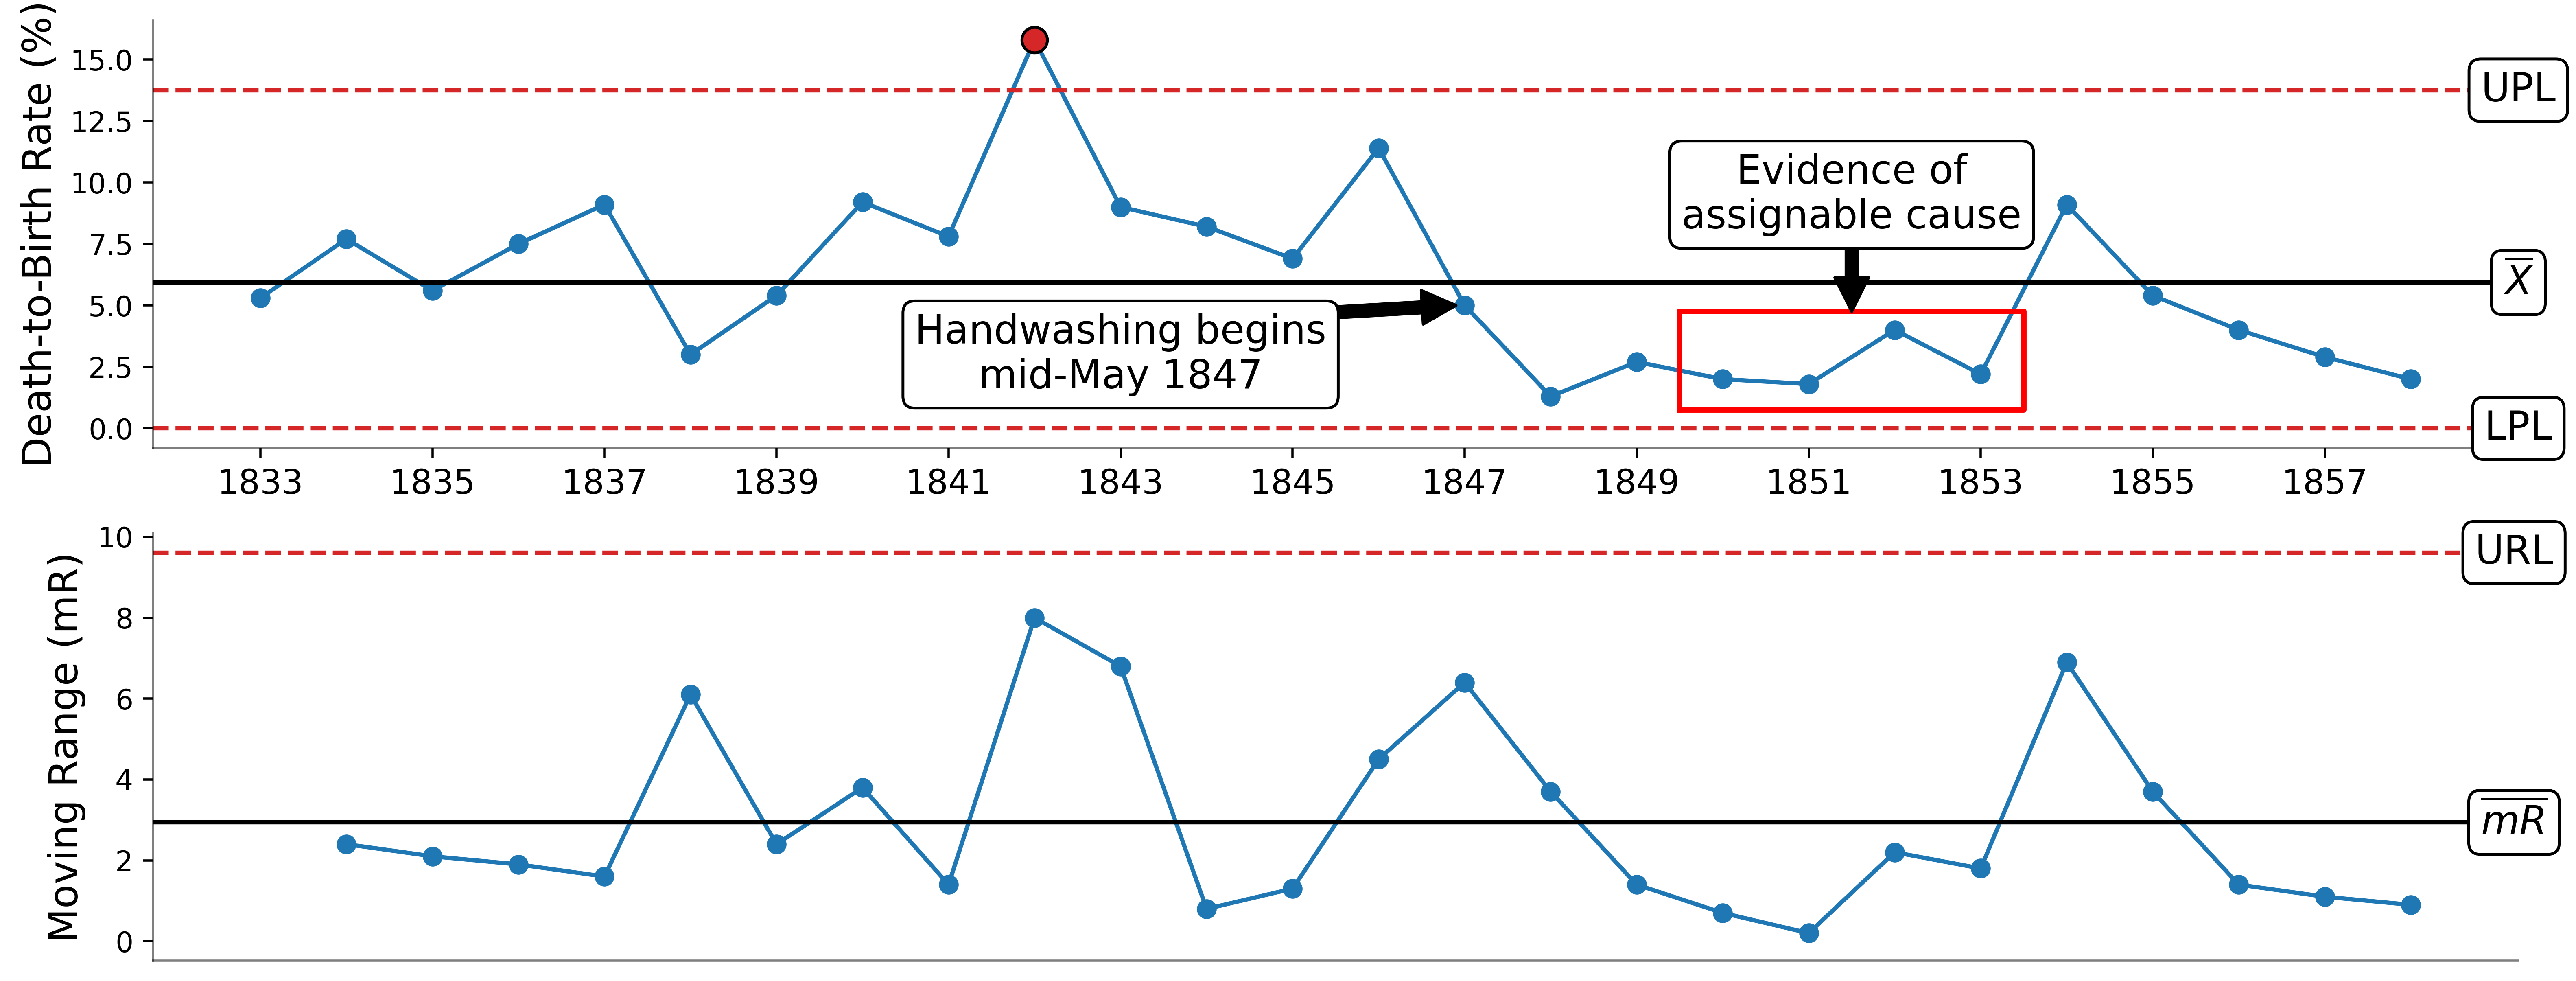

In [40]:
# Specify tickinterval
tickinterval = 2

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
# Create masking parameters for values greater than URL on mR-chart
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)
url_less = np.ma.masked_where(moving_ranges > URL, moving_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean,'-','black'), (UPL,'--','tab:red'), (LPL,'--','tab:red')]
mrchart_lines = [(ave_mR,'-','black'), (URL,'--','tab:red')]

# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
xchart_labels = [(UPL,UPL),(LPL,LPL),(mean,mean)]
# Create list of tuples with y-coordinate and labels for mR-chart process limit and centerline
mrchart_labels = [(URL,URL),(ave_mR, ave_mR)]

# Create figure and axis
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,6), dpi=500)

# Plot data 
axs[0].plot(labels, data, marker='o')

# Plot moving ranges
axs[1].plot(labels, moving_ranges, marker='o')

# Add masking parameters to color values outside process limits
axs[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
axs[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
# Add masking parameters to color values greater than URL
axs[1].plot(labels, url_greater, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
axs[0].text(axs[0].get_xlim()[1], UPL, 'UPL', color='black', ha='center', va='center', 
            fontsize=14, bbox=bbox_props)
axs[0].text(axs[0].get_xlim()[1], LPL, 'LPL', color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)
axs[0].text(axs[0].get_xlim()[1], mean, r'$\overline{X}$', color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)

axs[1].text(axs[1].get_xlim()[1], URL, 'URL', color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)
axs[1].text(axs[1].get_xlim()[1], ave_mR, r'$\overline{mR}$', color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)

# Add centerline and process limits 
for value, line, color in xchart_lines:
    axs[0].axhline(value, ls=line, c=color)
    
# Add centerline and process limits 
for value, line, color in mrchart_lines:
    axs[1].axhline(value, ls=line, c=color)

# Set the x-tick labels with increased intervals
tick_interval = tickinterval  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
axs[0].set_xticks(tick_positions)
axs[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center', fontsize=12)
# Remove ticks on axs[1]
axs[1].set_xticks([])

# Color values in the moving range white (applies to first value for visual offset)
for xi, yi in zip(labels, moving_ranges):
    if np.isnan(yi):
        plt.plot(xi, 0, marker='x', color='white', markersize=0) 

# Add box for highlighting range of values satisfying Rule 3
start_index = 16.5
end_index = 20.5  
y_min = 0.75  
y_max = 4.75    

# Add a border using plt.plot()
axs[0].plot([start_index, end_index, end_index, start_index, start_index], 
         [y_min, y_min, y_max, y_max, y_min], color='red', linewidth=2)

annotations = [ 
    ('Handwashing begins\nmid-May 1847', (13.9,5), (10, 3)), 
    ('Evidence of\nassignable cause', (18.5, 4.75), (18.5, 9.5)),
#     ('Evidence of\nassignable cause', (9.2,15.8), (12.55, 15.8))
]

# Add annotations using a loop
for text, xy, xytext in annotations:
    axs[0].annotate(text, xy=xy, xytext=xytext,
                ha='center', va='center', fontsize=14,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'),
                arrowprops=dict(facecolor='black'))

# Specify axis labels and title
axs[0].set_xlabel("",fontsize=12)
axs[0].set_ylabel("Death-to-Birth Rate (%)", fontsize=14)
axs[0].set_title("", fontsize=14)

axs[1].set_xlabel("")
axs[1].set_ylabel("Moving Range (mR)", fontsize=14)

# Specify spine visibility 
sns.despine()
for val in (0,1):
    axs[val].spines[['left','bottom']].set_alpha(0.5)

# Show plot
plt.show()

## Fig 2.6: Comparison of death-to-birth rates before and after handwashing, using XmR charts

In [41]:
# Split first clinic into 'Before' and 'After' hand washing
before_washing = first_clinic[:14]
after_washing = first_clinic[14:].reset_index(drop=True)

# Create dataframe list
df_list = [before_washing, after_washing]

# Create label list
subplot_titles_list = ['Before handwashing', 'After handwashing']

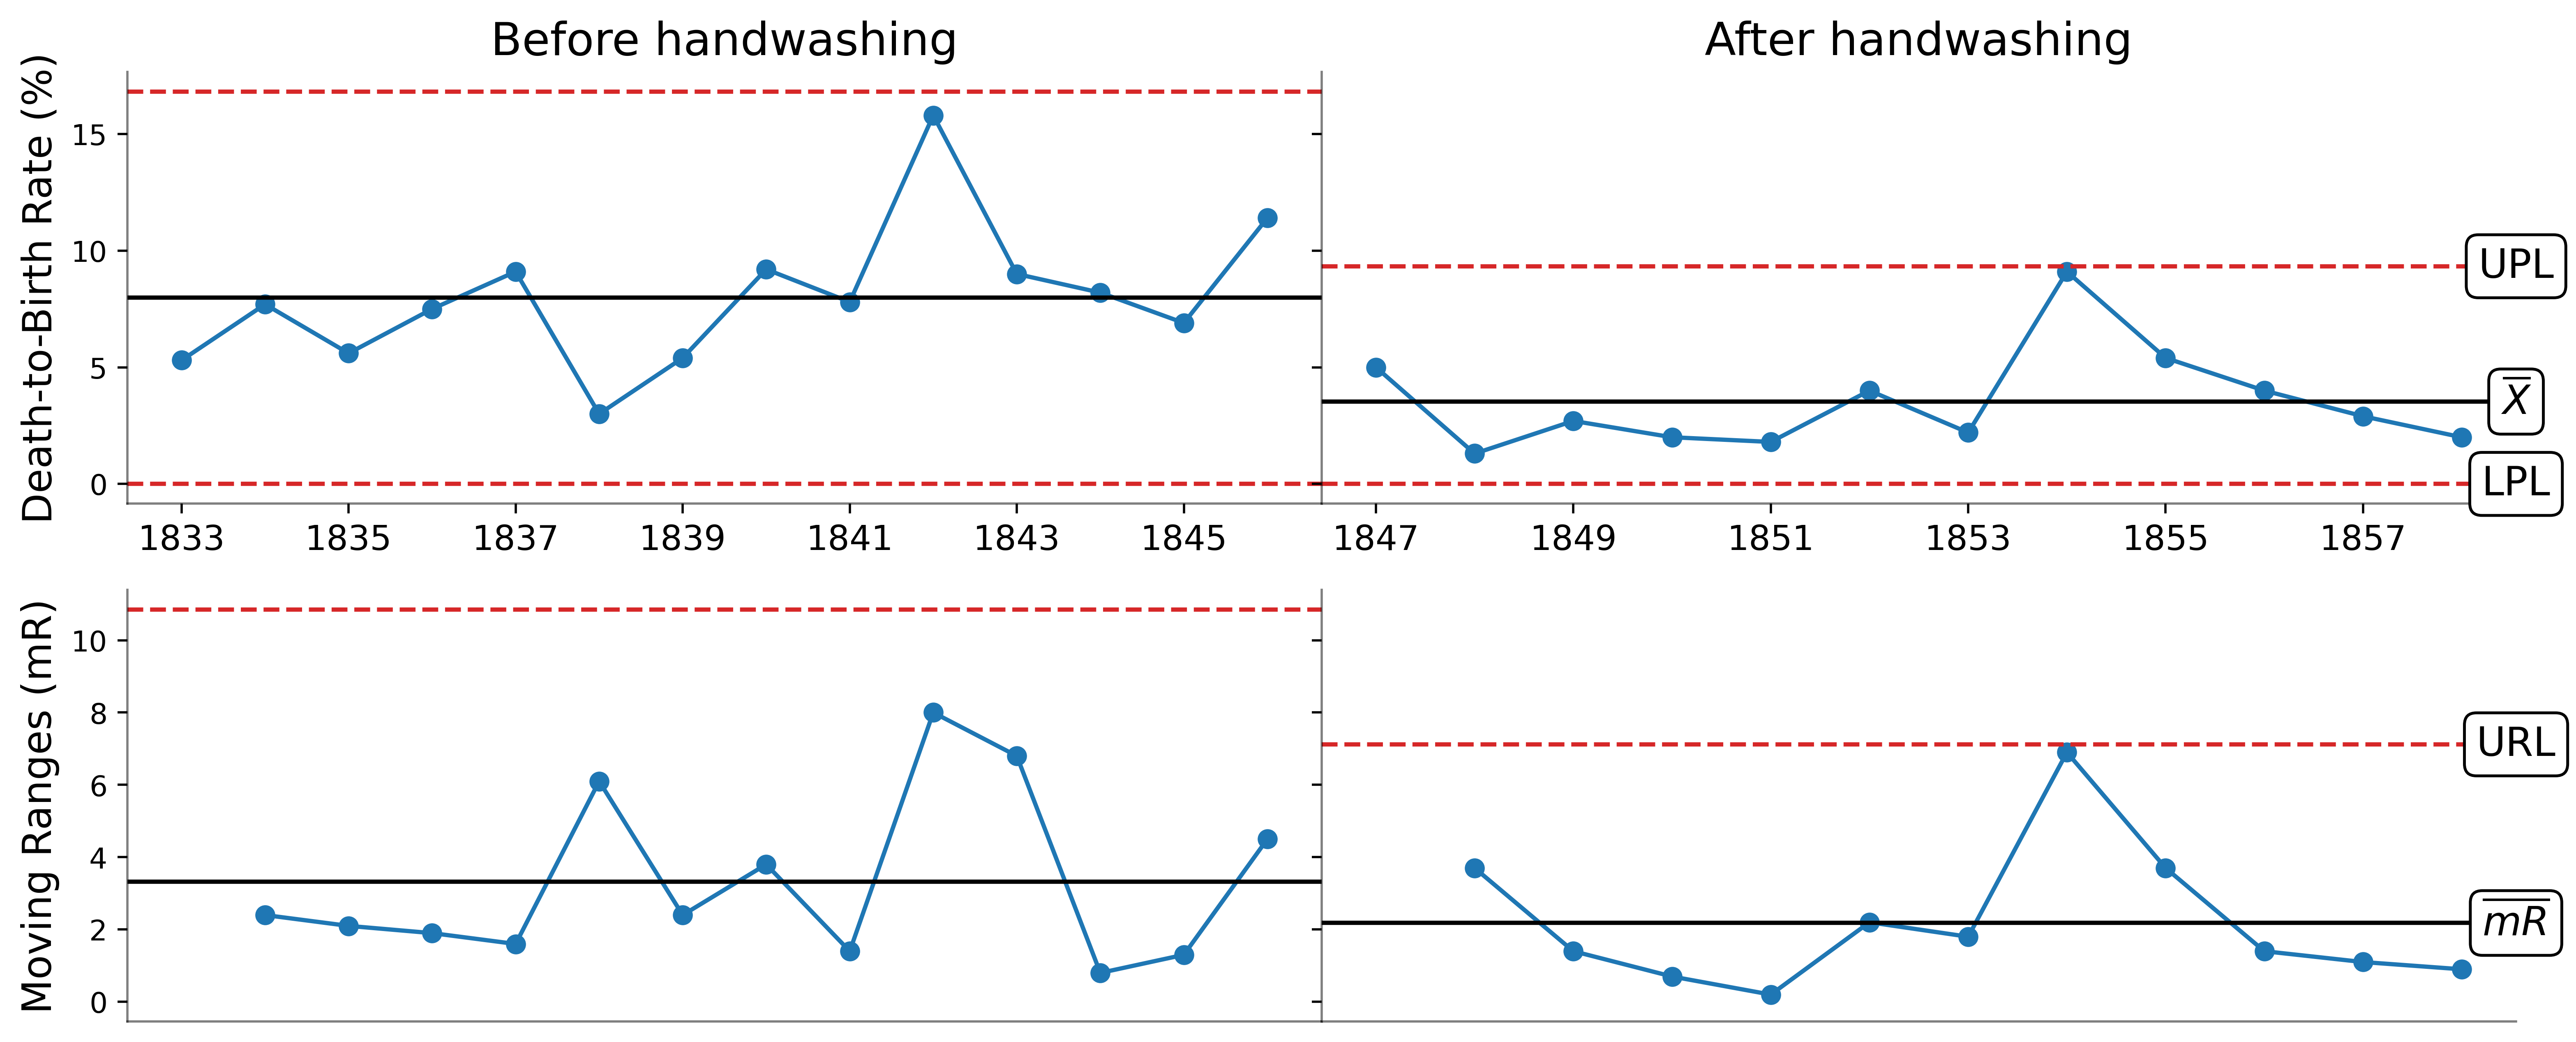

In [42]:
# Specify round_value
round_value = 2
tick_interval = 2
# Specify condition
condition = 'Rate'
labels = 'Year'

# Define plotting parameters
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), dpi=500, sharey='row')
plt.subplots_adjust(wspace=0)

# Initialize an empty list to store stats for each dataframe
stats_list = []

# Loop through the df_list and plot on the axes
for idx, (df, label) in enumerate(zip(df_list, subplot_titles_list)):

    data = df[condition]
    moving_range = round(abs(data.diff()), round_value).copy()
    moving_range.iloc[0] = np.nan
    xticks = df[labels]

    # Specify scaling factors
    E2 = 2.660
    D4 = 3.268

    # Calculate statistics for UPL and LPL
    mean = round(data.mean(), round_value)
    average_mR = round(moving_range.mean(), round_value)
    UPL = round(mean + (E2 * average_mR), round_value)
    LPL = round(max(mean - (E2 * average_mR), 0), round_value)
    URL = round(D4 * average_mR, round_value)

    # Characterize process
    if ((data < LPL) | (data > UPL)).any():
        characterization = "Unpredictable"
    elif (moving_range > URL).any():  # Add condition for moving range exceeding the URL
        characterization = "Unpredictable"
    else:
        characterization = "Predictable"

    # Store statistics in the list
    stats_list.append({
        'Label': label,
        'Mean': mean,
        'Ave. mR': average_mR,
        'UPL': UPL,
        'LPL': LPL,
        'URL': URL,
        'PRL': UPL-LPL,
        'Characterization': characterization
    })
    
    # Plot individual values in the first two subplots (top row)
    axes[0, idx].plot(data, marker='o')
    # Masking and plotting limits
    axes[0, idx].plot(np.ma.masked_where(data < UPL, data), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)
    axes[0, idx].plot(np.ma.masked_where(data > LPL, data), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)
    axes[0, idx].set_title(label, fontsize=16)

    # Add UPL and LPL horizontal lines for individual values plot
    axes[0, idx].axhline(UPL, color='tab:red', linestyle='--')
    axes[0, idx].axhline(LPL, color='tab:red', linestyle='--')
    axes[0, idx].axhline(mean, color='black', linestyle='-')
    
    # Set x-tick labels with separate intervals
    tick_positions = np.arange(0, len(xticks), tick_interval)
        
    axes[0, idx].set_xticks(tick_positions)
    axes[0, idx].set_xticklabels(xticks.iloc[tick_positions], rotation=0, ha='center', fontsize=12)

    # Plot moving range in the second row
    axes[1, idx].plot(moving_range, marker='o')
    
    # Offset moving range by 1 relative to the individual values
    for xi, yi in zip(labels, moving_range):
        if np.isnan(yi):
            axes[1, idx].plot(xi, 0, marker='x', color='white', markersize=0)

    # Add UPL and LPL horizontal lines for moving range plot
    axes[1, idx].axhline(URL, color='tab:red', linestyle='--')
    axes[1, idx].axhline(average_mR, color='black', linestyle='-')
    axes[1, idx].plot(np.ma.masked_where(moving_range < URL, moving_range), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)

    # Add label to y-axes
    axes[0, 0].set_ylabel('Death-to-Birth Rate (%)', fontsize=14)
    axes[1, 0].set_ylabel('Moving Ranges (mR)', fontsize=14)
    
    # Establish bbox properties
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)

    # Add labels to 2nd and 4th plots
    if idx == 1:
        axes[0, idx].text(axes[0, idx].get_xlim()[1], UPL, 'UPL', color='black', ha='center', va='center',
                          fontsize=14, bbox=bbox_props)
        axes[0, idx].text(axes[0, idx].get_xlim()[1], LPL, 'LPL', color='black', ha='center', va='center', 
                          fontsize=14, bbox=bbox_props)
        axes[0, idx].text(axes[0, idx].get_xlim()[1], mean, r'$\overline{X}$', color='black', ha='center', va='center',
                          fontsize=14, bbox=bbox_props)

    if idx == 1:
        axes[1, idx].text(axes[1, idx].get_xlim()[1], URL, 'URL', color='black', ha='center', va='center', 
                          fontsize=14, bbox=bbox_props)
        axes[1, idx].text(axes[1, idx].get_xlim()[1], average_mR, r'$\overline{mR}$', 
                          color='black', ha='center', va='center', 
                          fontsize=14, bbox=bbox_props)

    # Remove ticks on xticks for moving ranges
    axes[1, idx].set_xticks([])
    
    # Loop through the axes and set spine width
    for ax_row in axes:
        for ax in ax_row:
            for spine in ax.spines.values():
                spine.set_alpha(0.5)

# Stylize plots
sns.despine()
    
# Convert stats list into DataFrame
stats_df = pd.DataFrame(stats_list)

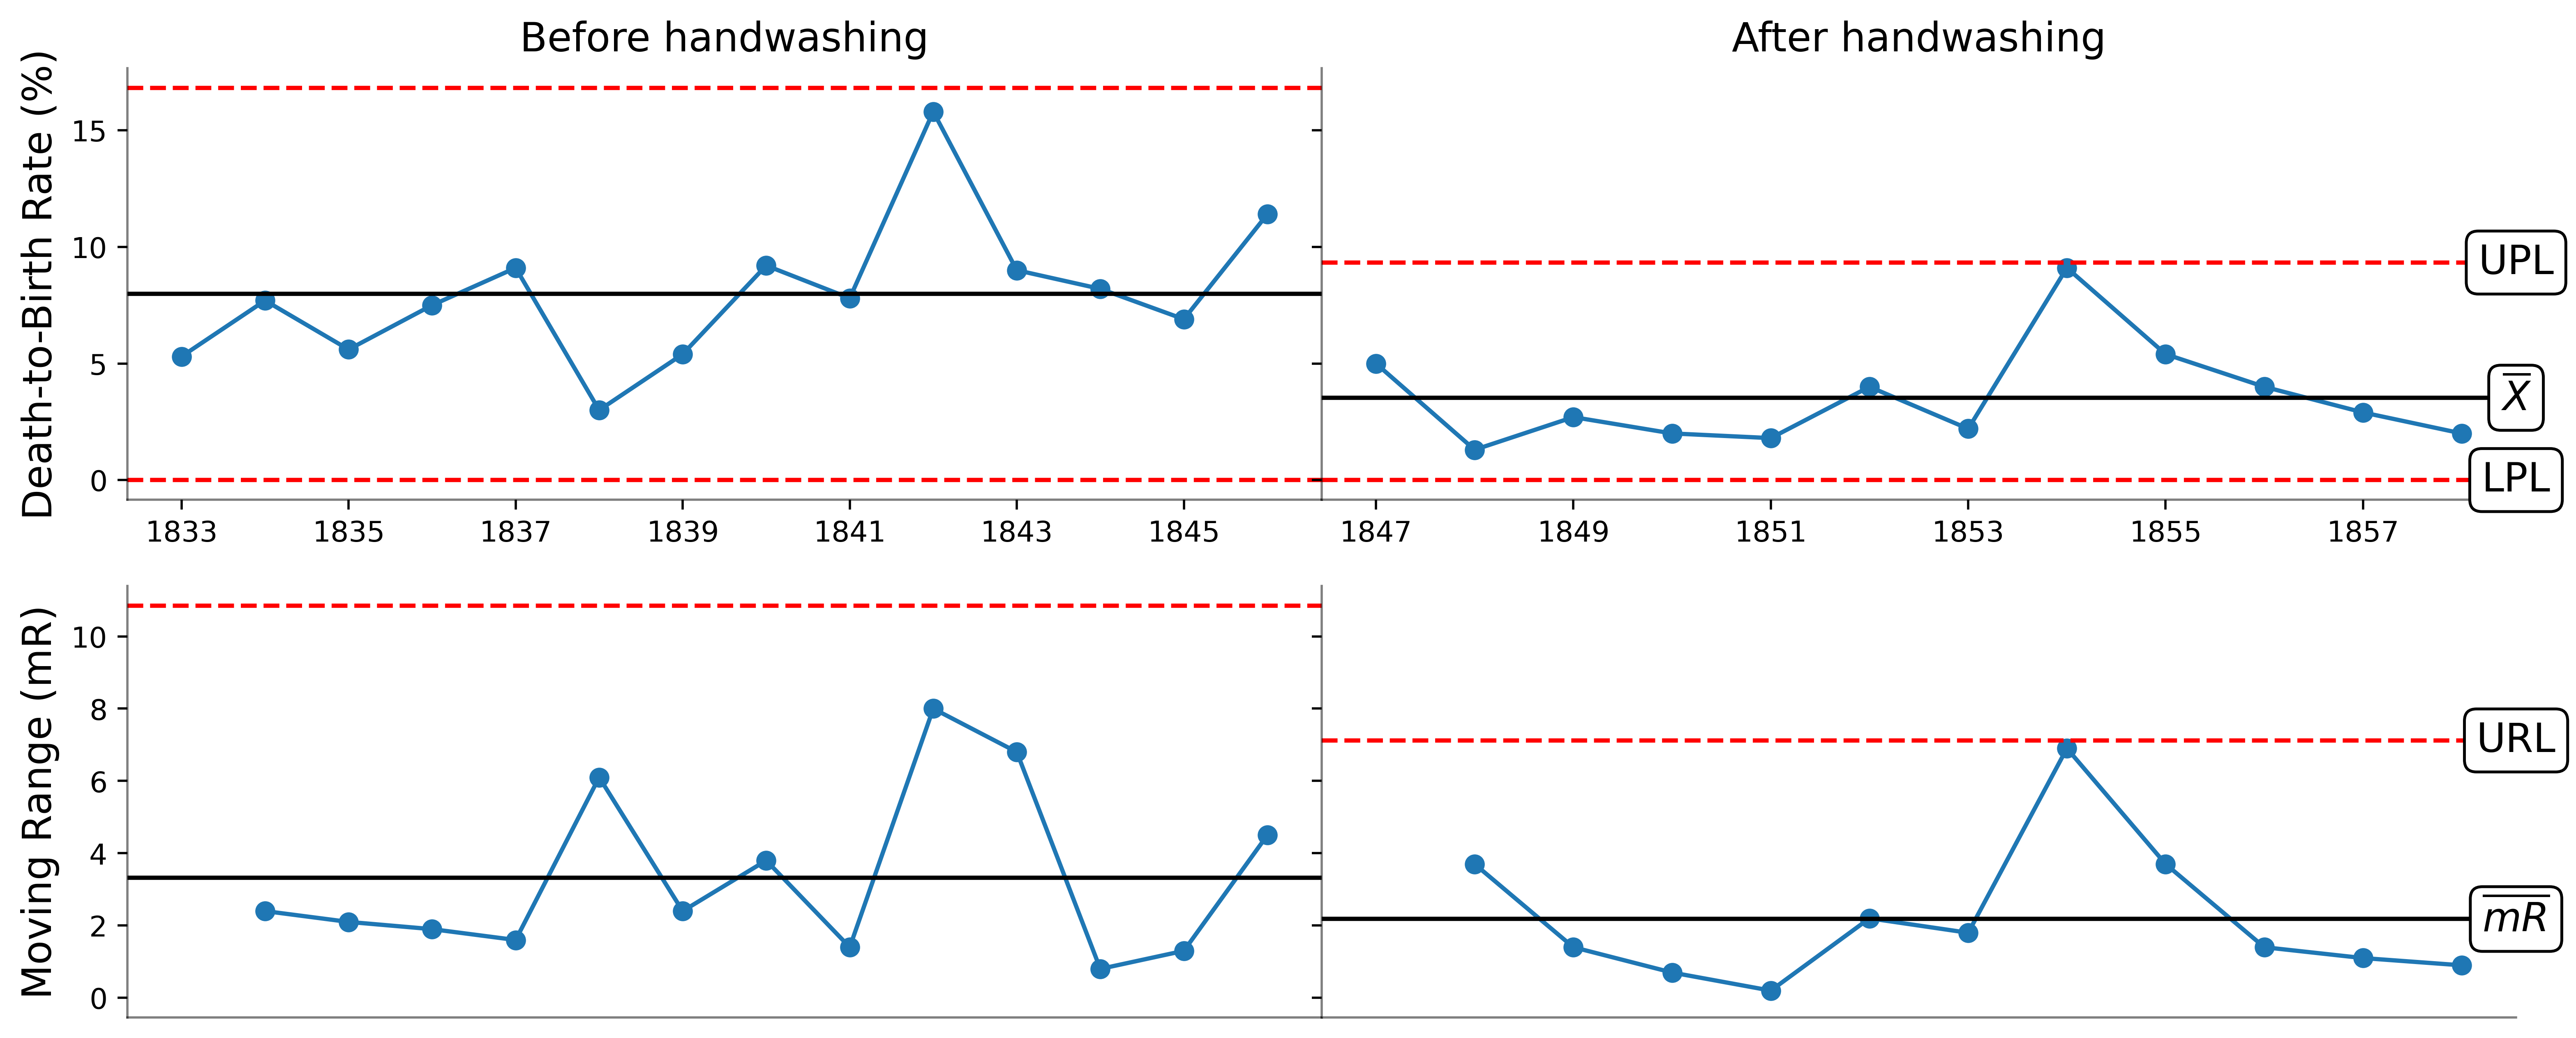

In [43]:
# This comparison uses the process_improvement.py libraray function comparison_chart.xmr_comparison.
# The library can be installed with pip install process_improvement.
comparison_results = cc.xmr_comparison(df_list, 
                                       'Rate', 
                                       'Year', 
                                       subplot_titles_list,
                                       xchart_ylabel = 'Death-to-Birth Rate (%)',
                                       tickinterval=2, 
                                       dpi=600)

In [44]:
comparison_results

,Label,Mean,Ave. mR,UPL,LPL,URL,PLR,Characterization
0,Before handwashing,7.99,3.32,16.8212,0,10.85,16.8212,Predictable
1,After handwashing,3.53,2.18,9.3288,0,7.12,9.3288,Predictable
